In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from warnings import filterwarnings
import pathlib

import keras
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential

import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np
import pandas as pd
import seaborn as sns
import splitfolders
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

filterwarnings('ignore')


2024-07-19 15:07:00.107204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 15:07:00.107310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 15:07:00.236920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

images = []
labels = []

for subfolder in os.listdir(df_path):
    
    subfolder_path = os.path.join(df_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  

    for image_filename in os.listdir(subfolder_path):

        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
df = pd.DataFrame({'image': images, 'label': labels})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   75000 non-null  object
 1   label   75000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


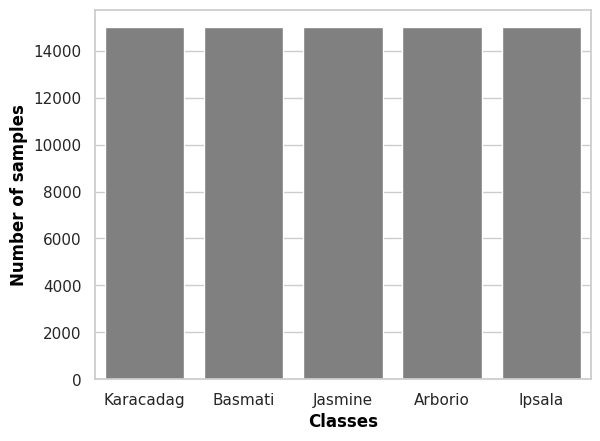

In [5]:
sns.set(style="whitegrid", palette="pastel")

ax = sns.countplot(x=df.label, color="gray")

ax.set_xlabel("Classes", fontdict={'weight': 'bold'})
ax.xaxis.label.set_color('black')

ax.set_ylabel("Number of samples", fontdict={'weight': 'bold'})
ax.yaxis.label.set_color('black')

plt.show()

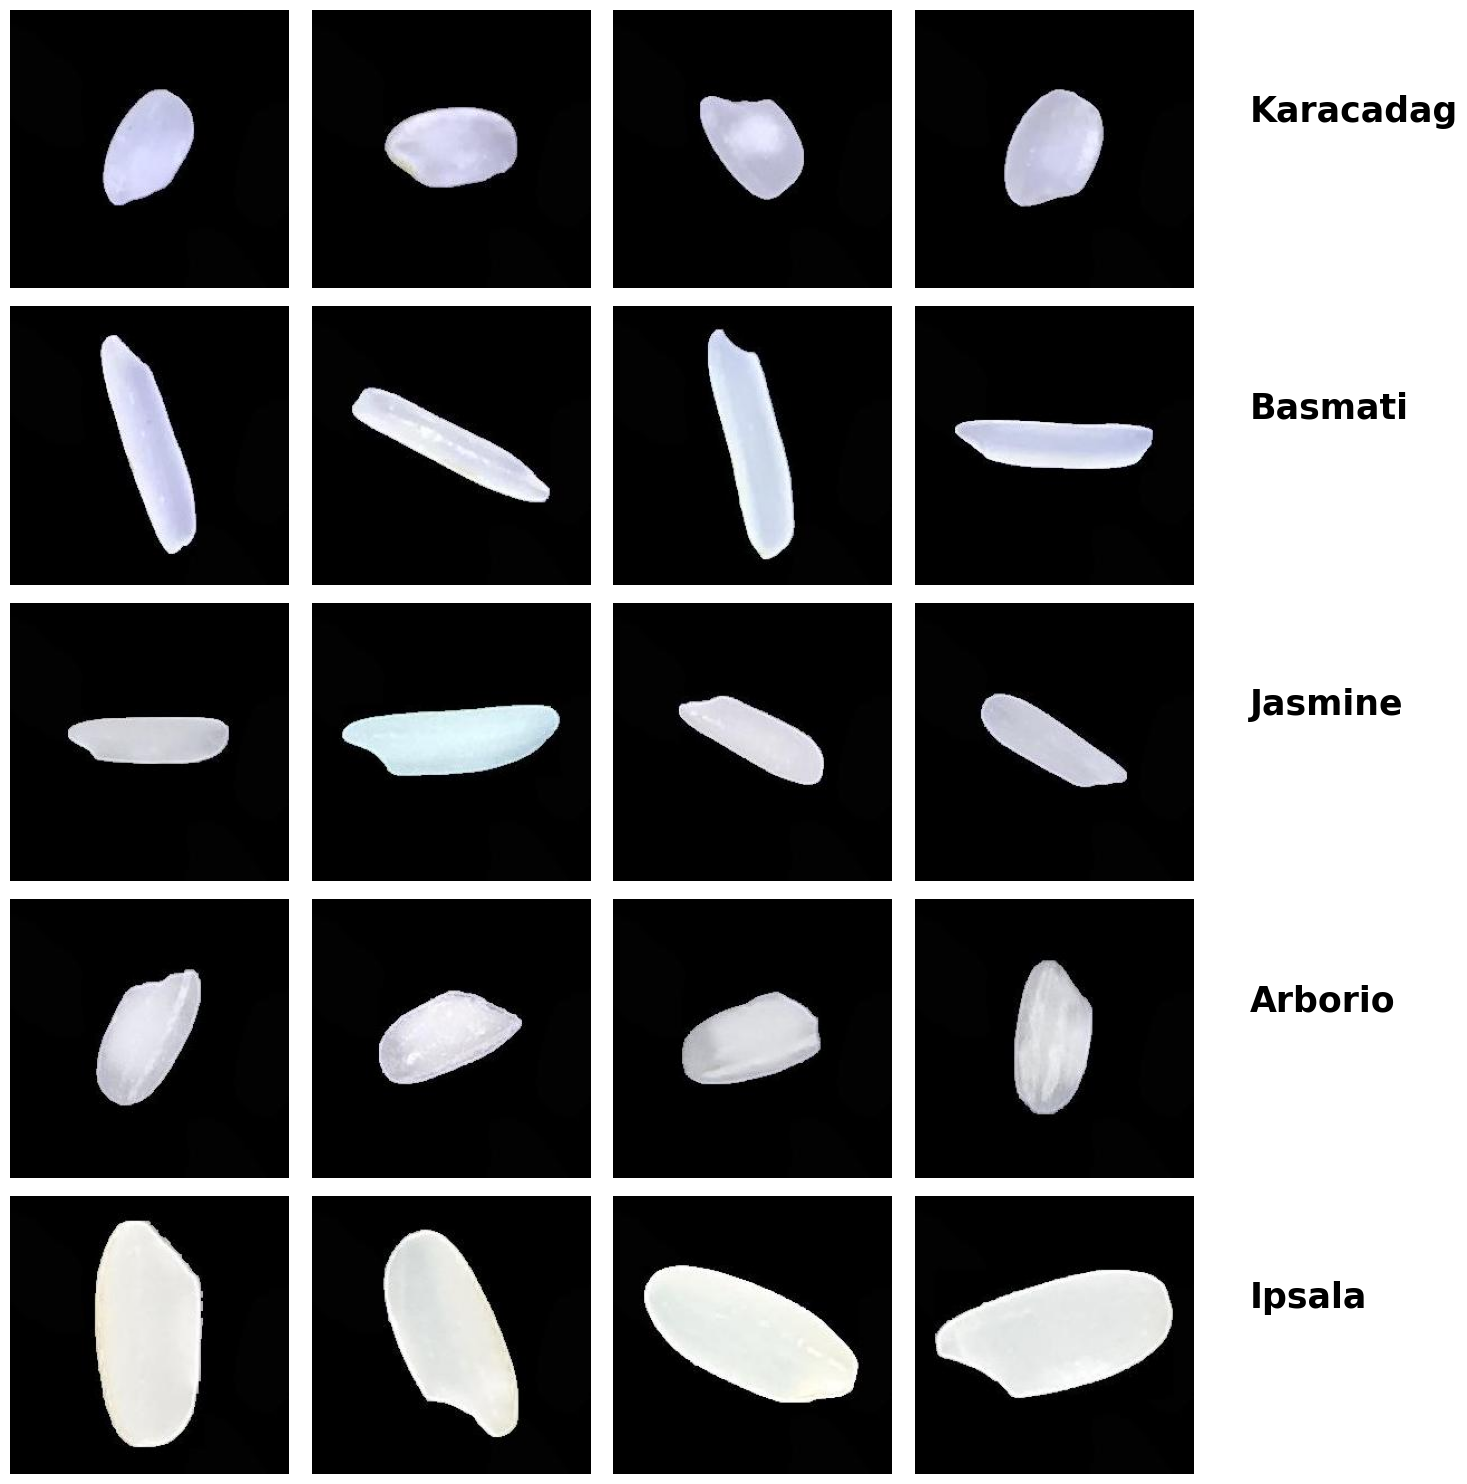

In [6]:
fig, axs = plt.subplots(5, 4, figsize=(15, 15))

categories = df['label'].unique()
num_categories = len(categories)

for i, category in enumerate(categories):
   
    filepaths = df[df['label'] == category]['image'].values[:4]

    for j, filepath in enumerate(filepaths):
        ax = axs[i, j]
        image = imread(filepath)
        ax.imshow(image)
        ax.axis('off')

    ax.text(300, 100, category, fontdict={'weight': 'bold'}, fontsize=25, color='black')

plt.tight_layout()
plt.show()

In [7]:
df_path = pathlib.Path(df_path)

In [8]:
splitfolders.ratio(df_path, output='df_splitted', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [08:28, 147.61 files/s]


In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = (250, 250)

Train = keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/df_splitted/train',
    labels='inferred',
    label_mode='categorical',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    seed= 42
)

Test = keras.utils.image_dataset_from_directory(
    directory= '/kaggle/working/df_splitted/test',
    labels='inferred',
    label_mode= 'categorical',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    seed= 42
)

Validation = keras.utils.image_dataset_from_directory(
    directory= '/kaggle/working/df_splitted/val',
    labels= 'inferred',
    label_mode= 'categorical',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    seed= 42
)


Found 52500 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.


In [10]:
train_batch = next(iter(Train))
validation_batch = next(iter(Validation))
test_batch = next(iter(Test))

image_batch, labels_batch = train_batch
print(f"Train Shape: {image_batch.shape} (Batches = {len(Train)})")
print(f"Train label: {labels_batch.shape}\n")

image_batch, labels_batch = test_batch
print(f"Test Shape: {image_batch.shape} (Batches = {len(Test)})")
print(f"Test label: {labels_batch.shape}\n")

image_batch, labels_batch = validation_batch
print(f"Validation Shape: {image_batch.shape} (Batches = {len(Validation)})")
print(f"Validation label: {labels_batch.shape}\n")

Train Shape: (32, 250, 250, 3) (Batches = 1641)
Train label: (32, 5)

Test Shape: (32, 250, 250, 3) (Batches = 352)
Test label: (32, 5)

Validation Shape: (32, 250, 250, 3) (Batches = 352)
Validation label: (32, 5)



In [12]:
INPUT_SHAPE = (250, 250, 3)

cnn = Sequential()

cnn.add(Conv2D(6, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(16, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(120, activation='relu'))
cnn.add(Dense(84, activation='relu'))
cnn.add(Dense(5, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 248, 248, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 122, 122, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     7,144,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,156,077 (27.30 MB)

 Trainable params: 7,156,077 (27.30 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
CNN_model = cnn.fit(Train, validation_data= Validation, epochs=20,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='auto'))

Epoch 1/20


2024-07-19 15:24:49.397501: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61505: 5.79731, expected 4.97888
2024-07-19 15:24:49.397575: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61509: 6.26608, expected 5.44765
2024-07-19 15:24:49.397585: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61511: 6.90179, expected 6.08335
2024-07-19 15:24:49.397593: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61512: 7.16736, expected 6.34893
2024-07-19 15:24:49.397601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61516: 6.90608, expected 6.08765
2024-07-19 15:24:49.397609: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61517: 6.07541, expected 5.25697
2024-07-19 15:24:49.397617: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61518: 5.93499, expected 5.11655
2024-07-19 15:24:49.397625:

  10/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.2609 - loss: 416.9977

I0000 00:00:1721402692.738875     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8987 - loss: 15.0638

2024-07-19 15:25:32.759238: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.47447, expected 4.7136
2024-07-19 15:25:32.759295: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.57805, expected 5.81718
2024-07-19 15:25:32.759304: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.85041, expected 5.08954
2024-07-19 15:25:32.759312: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.34728, expected 5.5864
2024-07-19 15:25:32.759319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.40365, expected 5.64277
2024-07-19 15:25:32.759327: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 6.17438, expected 5.41351
2024-07-19 15:25:32.759335: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 6.51328, expected 5.7524
2024-07-19 15:25:32.759343: E external/local_xla/xla/ser

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - accuracy: 0.8987 - loss: 15.0562 - val_accuracy: 0.9782 - val_loss: 0.0707
Epoch 2/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9811 - loss: 0.0595 - val_accuracy: 0.9737 - val_loss: 0.0840
Epoch 3/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9758 - loss: 0.0696 - val_accuracy: 0.9776 - val_loss: 0.0716
Epoch 4/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9829 - loss: 0.0507 - val_accuracy: 0.9676 - val_loss: 0.1101
Epoch 5/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9808 - loss: 0.0560 - val_accuracy: 0.9660 - val_loss: 0.1424
Epoch 6/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9887 - loss: 0.0319 - val_accuracy: 0.9653 - val_loss: 0.1573
Epoch 7/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9900 - loss: 0.0302 - val_accuracy: 0.9676 - val_loss: 0.1573
Epoch 8/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9837 - loss: 0.0

In [14]:
training_loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
training_acc = CNN_model.history['accuracy']
val_acc  = CNN_model.history['val_accuracy']

In [15]:
epoch_count = np.arange(1, len(training_loss) + 1)

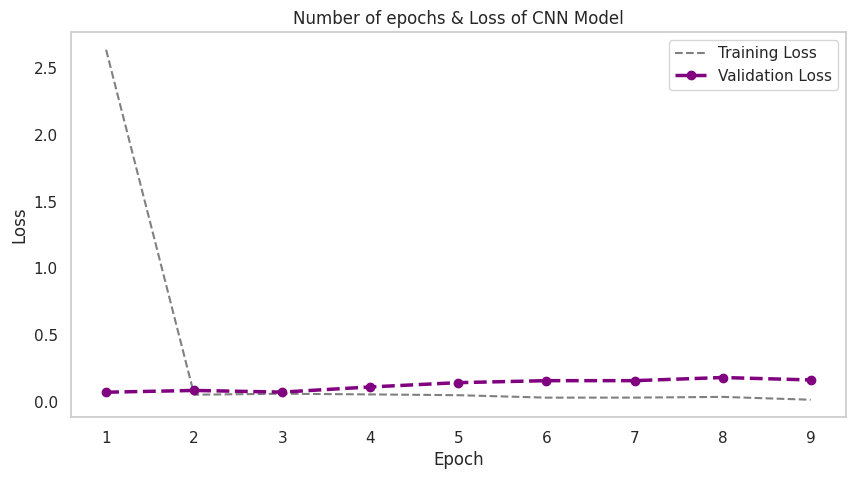

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(epoch_count, training_loss, 'r--', color='gray', label='Training Loss')
ax.plot(epoch_count, val_loss, '--bo', color='purple', linewidth=2.5, label='Validation Loss')

ax.legend()
ax.set_title('Number of epochs & Loss of CNN Model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.set_xticks(np.arange(1, 10))
ax.grid(False)

plt.show()

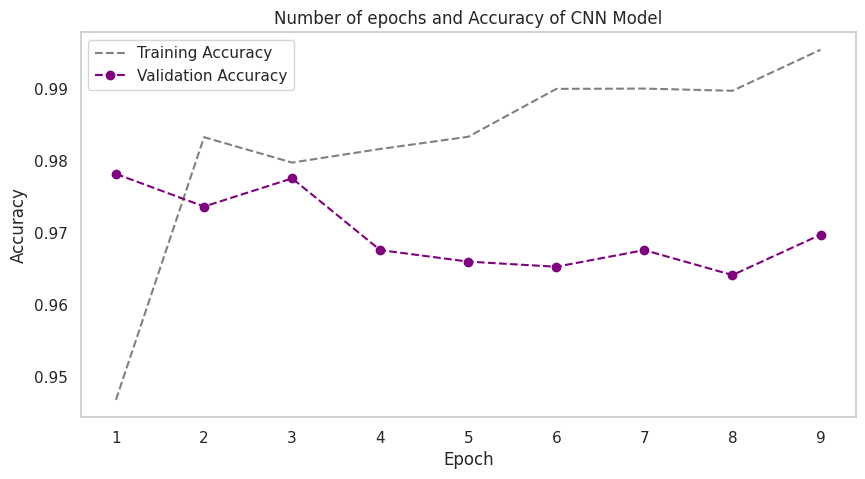

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(epoch_count, training_acc, 'r--', color='gray', label='Training Accuracy')
ax.plot(epoch_count, val_acc, '--bo', color='purple', label='Validation Accuracy')

ax.legend()
ax.set_title('Number of epochs and Accuracy of CNN Model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.set_xticks(np.arange(1, 10))
ax.grid(False)

plt.show()

In [22]:
cnn.save('model.h5')

In [23]:
last_model = tf.keras.models.load_model('model.h5')
last_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 248, 248, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 122, 122, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     7,144,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,156,079 (27.30 MB)

 Trainable params: 7,156,077 (27.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [24]:
test_loss, test_acc = last_model.evaluate(Test)
print(f'\nTest accuracy:{test_acc:.5f}\ntest_loss: {test_loss:.5f}')

352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9728 - loss: 0.1273

Test accuracy:0.97422
test_loss: 0.12918


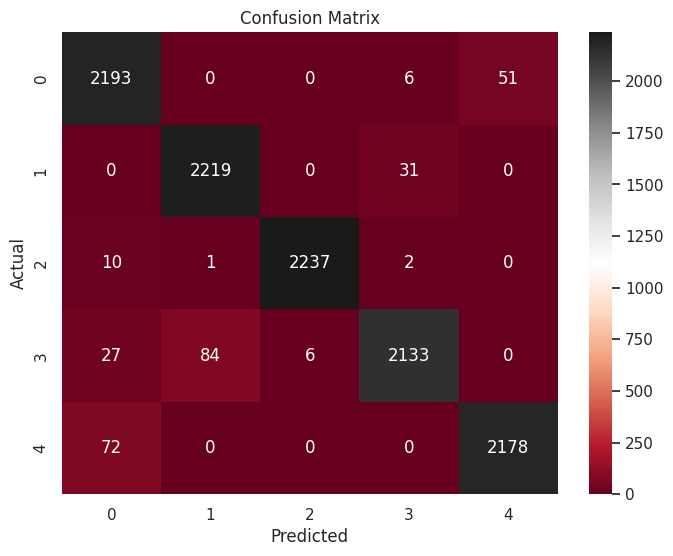


Classification Report:
               precision    recall  f1-score   support

     Arborio       0.95      0.97      0.96      2250
     Basmati       0.96      0.99      0.97      2250
      Ipsala       1.00      0.99      1.00      2250
     Jasmine       0.98      0.95      0.96      2250
   Karacadag       0.98      0.97      0.97      2250

    accuracy                           0.97     11250
   macro avg       0.97      0.97      0.97     11250
weighted avg       0.97      0.97      0.97     11250



In [25]:
predictions = []
true_labels = []
class_names = [
    "Arborio",
    "Basmati",
    "Ipsala",
    "Jasmine",
    "Karacadag"
    ]

for batch in Test:
    images, labels = batch
    batch_predictions = cnn.predict(images, verbose=0)
    predictions.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

predictions = np.array(predictions)
true_labels = np.array(true_labels)

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdGy')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(true_labels, predictions, target_names=class_names)
print("\nClassification Report:\n", class_report)